In [10]:
# Adjoint SWE Solver (v13-01)

%reload_ext autoreload 
# enables automatic reloading of modules before executing code
%autoreload 2 
# set to reload all modules (except those excluded by %aimport) every time before executing the Python code typed
import sys
#print("System path:", sys.executable)
#print("Python version:", sys.version)

# --- Python core packages ---
import numpy as np
import matplotlib.pyplot as plt
from pyadjoint import *

# --- FEniCS core ---
import dolfin as dlf
from dolfin import (
    Constant, Function, FunctionSpace, VectorFunctionSpace, 
    TestFunctions, TrialFunctions, Expression, interpolate, assign
)

# --- dolfin-adjoint (import early so wrappers are active before constants/functions are created) ---
from dolfin_adjoint import *

# --- UFL symbolic tools ---
import ufl
from ufl import dot, div, grad, nabla_grad, sqrt, inner, derivative, Measure

# --- PETSc bindings for parallel linear algebra ---
from petsc4py import PETSc

from Functions_optimisation_SWE import *

print("SWE solver ready (v13-01)")

SWE solver ready (v13-01)


In [11]:
# Step 2 — Base physical & numerical parameters
# Define constants and parameters for the SWE model
# --- Physical constants ---
rho  = Constant(1025.0)     # density [kg/m³]
g    = Constant(9.81)       # gravity [m/s²]
nu   = Constant(1.0)        # eddy viscosity [m²/s]
h0   = Constant(40.0)       # mean depth [m]
# --- Turbine and drag coefficients ---
C_T = 0.7                   # thrust coefficient
C_D = 0.0025                # background drag coefficient
D = 5.0                     # turbine diameter [m]
sigma = 0.5*D               # gaussian width [m]
A_T = np.pi * D**2          # turbine swept area [m²]

# --- Flow and boundary data ---
U_inflow = 2.0              # deth-averaged inflow velocity [m/s]
initial_condition_u = Constant((2.0, 0.0))  # initial velocity field
initial_condition_eta = Constant(0.0)       # initial free surface elevation

# --- Domain size and mesh resolution ---
Lx, Ly = 800.0, 1400.0    # domain dimensions [m]
Nx, Ny = 50, 40          # mesh resolution

# --- Turbine layout parameters ---
n_turbines = 21 # number of turbines
min_spacing = 2 * D # minimum spacing between turbines [m]

xn = 3  # number of turbines in x-direction
yn = n_turbines/xn # number of turbines in y-direction

# --- Plot toggles ---
show_mesh_plot = True # toggle to plot the mesh
show_plot_turbines = True # toggle to show turbine layout plot
show_turbines_coordinates = True # toggle to show turbine coordinates


print(f"Base parameters initialized successfully, Zoë.")

Base parameters initialized successfully, Zoë.


Mesh and mixed space initialised.


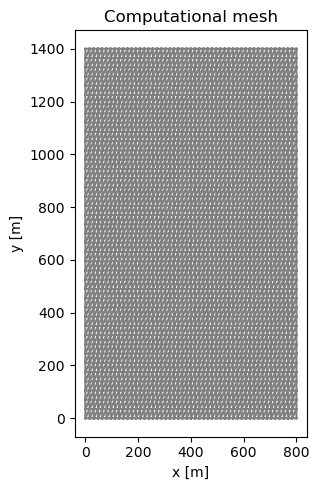

Boundary markers created and BCs applied:
   - Inlet  (ID=1): inflow velocity = 2.00 m/s
   - Outlet (ID=2): open boundary (no Dirichlet BC)
   - Walls  (ID=3): free‑slip (no Dirichlet BC)



In [12]:
#setting up mesh and initial configurations

mesh, W, w, u, eta, v, q = mesh_set_up(Lx, Ly, Nx, Ny, show_mesh_plot)

boundary_markers, bcs = setup_boundary_markers_and_bcs(mesh, W, Lx, Ly, U_inflow)